# Method 1: Full Dreambooth Fine-Tuning
This method creates a completely new model checkpoint by fully fine-tuning the UNet component of Stable Diffusion. The resulting model is larger but self-contained.

Cell 1: Install Libraries
This cell installs all the specific versions of the Python libraries required for the full fine-tuning process.
It first installs PyTorch and its related libraries (torchvision, torchaudio) that are compatible with CUDA 11.8.
It then installs the correct versions of Diffusers, Transformers, and other necessary Hugging Face libraries.
Finally, it installs bitsandbytes to enable the memory-efficient 8-bit Adam optimizer.

In [1]:
# =======================================================================================
# STEP 1: INSTALL LIBRARIES
# =======================================================================================
print(" STEP 1: Installing all required libraries...")


# Install PyTorch with CUDA 11.8
!pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cu118

# Install other core libraries
!pip install diffusers==0.27.2 transformers==4.39.3 accelerate==0.29.1 xformers==0.0.25 peft==0.7.1 huggingface-hub==0.20.3

# Install bitsandbytes for 8-bit optimizer
!pip install bitsandbytes==0.43.0

print(" STEP 1: Finished!")

 STEP 1: Installing all required libraries...
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.2/819.2 MB 2.3 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 2.1 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 68.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 94.3 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.1 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 30.0 MB/s eta 0:00:00:00

Cell 2: Set Up Environment
This cell configures the environment variables for the training process.
CUDA_LAUNCH_BLOCKING is set to "1" which can help with debugging CUDA errors by making GPU operations synchronous.
TF_CPP_MIN_LOG_LEVEL is set to "3" to suppress TensorFlow's less critical log messages.

In [2]:
# =======================================================================================
# STEP 2: SETUP THE ENVIRONMENT
# =======================================================================================
print("\n STEP 2: Setting up the environment...")
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
print(" STEP 2: Finished!")


 STEP 2: Setting up the environment...
 STEP 2: Finished!


Cell 3: Download Training Script
This cell downloads the official training scripts from the Hugging Face Diffusers repository on GitHub.
It uses git clone to get the entire repository.
It specifically checks out the v0.27.2 branch to ensure the script version matches the installed library versions.

In [3]:
# =======================================================================================
# STEP 3: DOWNLOAD THE TRAINING SCRIPT
# =======================================================================================
print("\n STEP 3: Downloading the training script from GitHub...")
!git clone --branch v0.27.2 https://github.com/huggingface/diffusers.git
print(" STEP 3: Finished!")


 STEP 3: Downloading the training script from GitHub...
Cloning into 'diffusers'...
remote: Enumerating objects: 94739, done.
remote: Counting objects: 100% (470/470), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 94739 (delta 374), reused 334 (delta 294), pack-reused 94269 (from 2)
Receiving objects: 100% (94739/94739), 70.27 MiB | 31.39 MiB/s, done.
Resolving deltas: 100% (69794/69794), done.
Note: switching to 'b69fd990ad8026f21893499ab396d969b62bb8cc'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to fal

Cell 4: Run DreamBooth Training
This is the main training command that fine-tunes the Stable Diffusion model on your images.
accelerate launch is used to run the script efficiently, handling both GPUs.
It specifies the base model (runwayml/stable-diffusion-v1-5), your image folder (--instance_data_dir), the output directory, and your unique prompt (--instance_prompt).
It sets training parameters like resolution, batch size, learning rate, and the number of training steps.
Crucially, --use_8bit_adam is enabled to save memory during training.

In [4]:
# =======================================================================================
# STEP 4: RUN THE DREAMBOOTH TRAINING 
# =======================================================================================
import time
import os
start_time = time.time()



print("\nSTEP 4: Starting VRAM-optimized training using BOTH GPUs...")
!accelerate launch diffusers/examples/dreambooth/train_dreambooth.py \
--pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
--instance_data_dir="/kaggle/input/my-selfies/Dataset" \
--output_dir="/kaggle/working/dreambooth-output" \
--instance_prompt="a photo of jainil person" \
--resolution=384 \
--train_batch_size=4 \
--gradient_accumulation_steps=1 \
--learning_rate=5e-6 \
--lr_scheduler="constant" \
--max_train_steps=350 \
--checkpointing_steps=175 \
--mixed_precision="fp16" \
--gradient_checkpointing \
--use_8bit_adam

training_time = time.time() - start_time
print(f"STEP 4: Finished in {training_time//60:.0f}m {training_time%60:.0f}s!")



STEP 4: Starting VRAM-optimized training using BOTH GPUs...
E0000 00:00:1749846644.977152     131 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749846644.977136     130 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749846645.036236     130 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1749846645.036257     131 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
tokenizer_config.json: 100%|███████████████████| 806/806 [00:00<00:00, 4.62MB/s]
vocab.json: 100%|██████████████████████████| 1.06M/1.06M [00:00<00:00, 17.0MB/s]
merges.txt: 100%|████████████████████████████| 525k/525k [00:00<00:00, 

Cell 5: Test the Trained Model
This final cell loads your newly fine-tuned model and generates a test image.
It loads the StableDiffusionPipeline from the output directory created in the previous step.
It then uses your unique prompt (a photo of sks person...) to generate an image and displays it directly in the notebook.
The generated image is also saved to the /kaggle/working/ directory.

E0000 00:00:1749847678.035013      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749847678.041933      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



STEP 5: Loading DreamBooth model and generating images...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Generating images with prompt: 'a photo of jainil person at the beach in sunglasses, high quality, detailed, sharp focus'...


  0%|          | 0/40 [00:00<?, ?it/s]

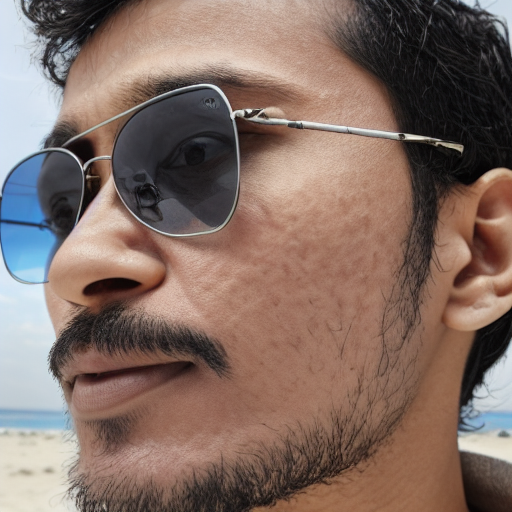

Saved: /kaggle/working/dreambooth_result_0.jpg


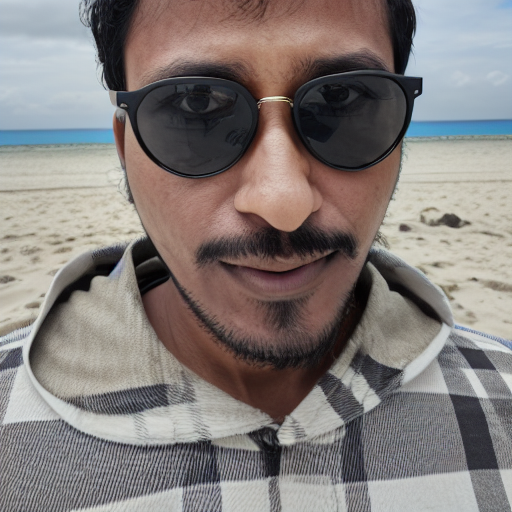

Saved: /kaggle/working/dreambooth_result_1.jpg


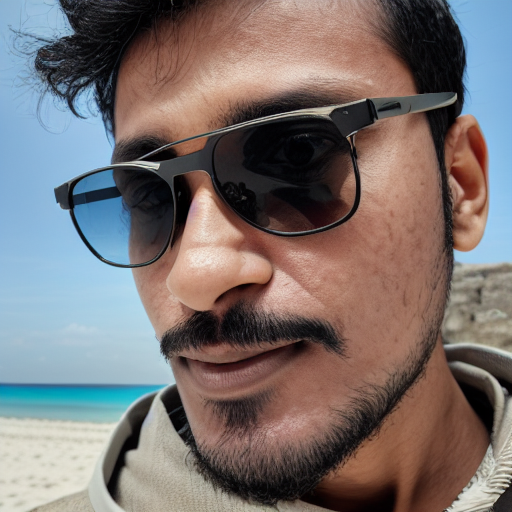

Saved: /kaggle/working/dreambooth_result_2.jpg


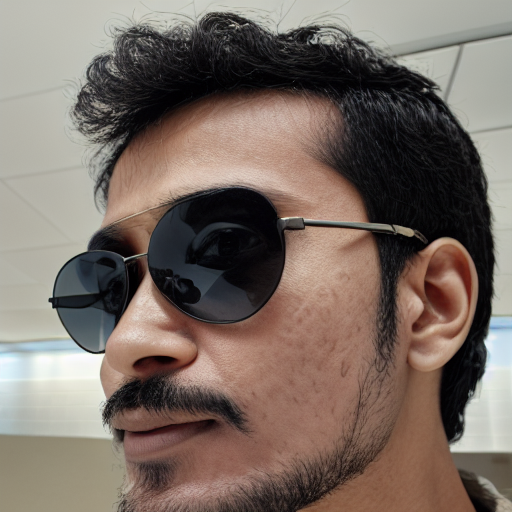

Saved: /kaggle/working/dreambooth_result_3.jpg

SUCCESS! Generated in 28.4 seconds


In [5]:
# =======================================================================================
# STEP 5: TEST DREAMBOOTH MODEL 
# =======================================================================================
import time
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
from IPython.display import display

start_time = time.time()
print("\nSTEP 5: Loading DreamBooth model and generating images...")

try:
    # Load model with updated scheduler
    pipe = StableDiffusionPipeline.from_pretrained(
        "/kaggle/working/dreambooth-output",
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    ).to("cuda")
    
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    
    # Generate multiple images
    prompt = "a photo of jainil person at the beach in sunglasses, high quality, detailed, sharp focus"
    negative_prompt = "blurry, low quality, deformed, extra limbs, watermark, signature"
    
    print(f"Generating images with prompt: '{prompt}'...")
    images = pipe(
        prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=40,
        num_images_per_prompt=4,  # Generate multiple options
        guidance_scale=7.5,
        generator=torch.Generator(device="cuda").manual_seed(42)
    ).images

    # Save and display images
    for i, img in enumerate(images):
        save_path = f"/kaggle/working/dreambooth_result_{i}.jpg"
        img.save(save_path)
        display(img)
        print(f"Saved: {save_path}")

    print(f"\nSUCCESS! Generated in {time.time()-start_time:.1f} seconds")

except Exception as e:
    print(f"ERROR: {e}")
    raise

Method 2: LoRA Fine-Tuning
This method is more memory-efficient. Instead of creating a whole new model, it trains a small "adapter" (the LoRA file) that gets loaded on top of the original Stable Diffusion model to apply your fine-tuned style.

Cell 1: Install & Update Libraries
This cell installs the necessary libraries for LoRA training, getting the latest development version of Diffusers directly from GitHub.
It then upgrades torch, transformers, peft, and other core libraries to their latest compatible versions.
Finally, it upgrades xformers and bitsandbytes for optimized performance and memory usage.

In [6]:
# =======================================================================================
# STEP 1: INSTALL & UPDATE LIBRARIES FOR LORA
# =======================================================================================
print(" STEP 1: Installing and updating libraries...")

# Install the latest diffusers and upgrade core libraries
!pip install git+https://github.com/huggingface/diffusers -q
!pip install --upgrade torch torchvision torchaudio transformers accelerate peft -q

# Upgrade additional performance libraries
!pip install --upgrade xformers bitsandbytes -q

print(" STEP 1: Finished!")

 STEP 1: Installing and updating libraries...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 9.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 79.4 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.39.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB

Cell 2: Prepare for LoRA Training
This cell sets up the environment for running the LoRA training script.
It changes the current directory to /kaggle/working/ to ensure the output files are saved correctly.
It then clones the diffusers repository from GitHub to get the training scripts.
Finally, it navigates into the specific folder containing the train_dreambooth_lora.py script.

In [7]:
# =======================================================================================
# STEP 2: PREPARE FOR LORA TRAINING
# =======================================================================================
print("\n STEP 2: Preparing training environment...")

%cd /kaggle/working
!git clone https://github.com/huggingface/diffusers.git -q
%cd diffusers/examples/dreambooth

print(" STEP 2: Finished!")


 STEP 2: Preparing training environment...
/kaggle/working
fatal: destination path 'diffusers' already exists and is not an empty directory.
/kaggle/working/diffusers/examples/dreambooth
 STEP 2: Finished!


Cell 3: Run LoRA Training
This is the command that starts the LoRA fine-tuning process.
It uses the train_dreambooth_lora.py script, which is specifically designed for this efficient method.
It sets the base model, your instance data, the output directory, and your unique prompt.
It also defines key training parameters like resolution, batch size, a higher learning rate (common for LoRA), and the number of training steps.

In [11]:
# =======================================================================================
# STEP 3: RUN THE LORA TRAINING 
# =======================================================================================
import time
start_time = time.time()

print("\nSTEP 3: Starting OPTIMIZED LoRA training process...")

# Run training with optimized parameters
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --instance_data_dir="/kaggle/input/my-selfies/Dataset" \
  --output_dir="/kaggle/working/output-lora" \
  --instance_prompt="a photo of jainil person" \
  --resolution=512 \
  --train_batch_size=4 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --max_train_steps=500 \
  --checkpointing_steps=500 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --rank=128 \
  --train_text_encoder



training_time = time.time() - start_time
print(f"STEP 3: Finished in {training_time//60:.0f}m {training_time%60:.0f}s!")



STEP 3: Starting OPTIMIZED LoRA training process...
E0000 00:00:1749848003.981894    2092 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749848003.982091    2091 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749848003.988875    2092 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1749848003.989049    2091 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'rescale_betas_zero_snr', 'sample_max_value', 'clip_sample_range', 

Cell 4: Generate Images with LoRA
This final cell loads the base Stable Diffusion model and then applies your trained LoRA weights on top of it.
The ImportError you saw in your original notebook happened at this stage, often due to library version mismatches.
pipe.load_lora_weights(out_dir) is the corrected, modern way to load the LoRA file.
It then generates images using your prompt, combining the power of the original model with your unique fine-tuned style from the LoRA adapter.

Files in output-lora:
['checkpoint-500', 'pytorch_lora_weights.safetensors', 'logs']


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]


LoRA Generated Images:


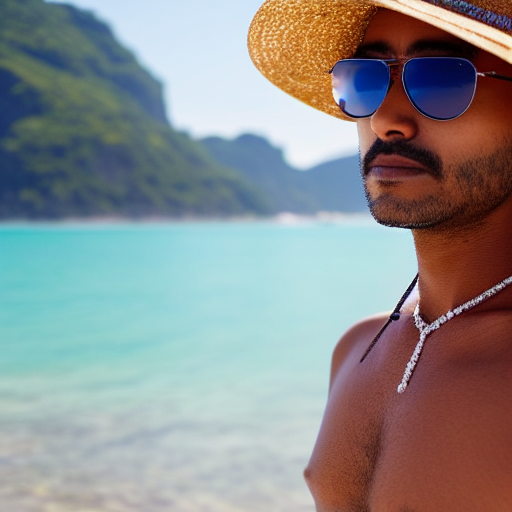

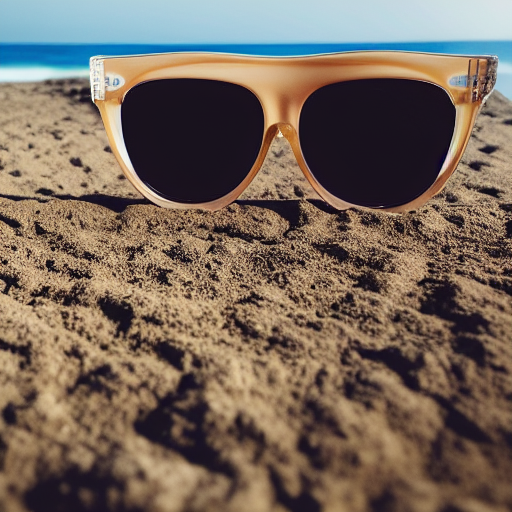

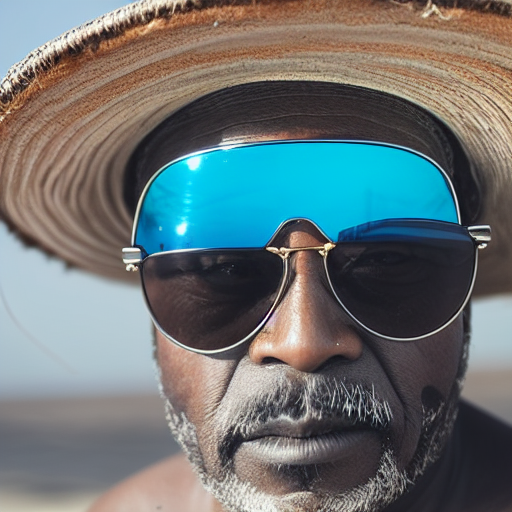

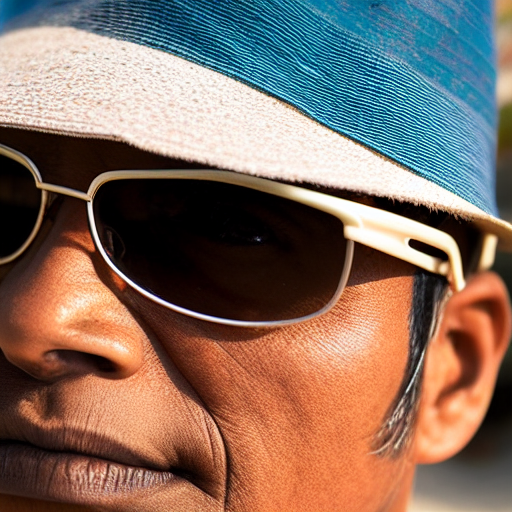

In [14]:
# Step 5: Generate Images with LoRA 
import os
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from IPython.display import display

# Configuration
out_dir = "/kaggle/working/output-lora"
base_model = "runwayml/stable-diffusion-v1-5"  # Use base model (not dreambooth output)

# Verify LoRA files
print("Files in output-lora:")
print(os.listdir(out_dir))

# Load base model with LoRA
pipe = StableDiffusionPipeline.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False
).to("cuda")

# Use updated scheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Load LoRA weights - PEFT integration
pipe.unet.load_attn_procs(out_dir)  # Works for both diffusers and PEFT formats

# Generate images
prompt = "a photo of jainil person at the beach in sunglasses, high quality, detailed, sharp focus"
negative_prompt = "blurry, low quality, deformed, extra limbs, watermark, signature"

images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=40,  # Increased for better detail
    num_images_per_prompt=4,  # Generate more options
    guidance_scale=7.5,
    generator=torch.Generator(device="cuda")  
).images

print("\nLoRA Generated Images:")
for i, img in enumerate(images):
    display(img)
    img.save(f"/kaggle/working/lora_result_{i}.png")

Cell 1: Install Libraries for CLIP
This cell handles the necessary setup by installing the transformers library from Hugging Face.
This library is essential because it contains the pre-trained CLIP model we'll use to score the images.


In [15]:
# =======================================================================================
# STEP 1: INSTALL LIBRARIES FOR CLIP
# =======================================================================================
print(" STEP 1: Installing compatible transformers library...")
!pip uninstall -y transformers
!pip install transformers==4.30.0 -q
print(" STEP 1: Finished!")


 STEP 1: Installing compatible transformers library...
Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 66.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires transformers>=4.33.1, but you have transformers 4.30.0 which is incompatible.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.30.0 which is incompatible.
 STEP 1: Finished!


Cell 2: Load CLIP Model and Tokenizer
This cell loads the powerful, pre-trained CLIP model (openai/clip-vit-base-patch32) and its matching processor.
The model is what understands the content of both images and text.
The processor is a helper that prepares your image and text prompt so the model can understand them.
It then moves the model to your GPU (.to("cuda")) to make the calculations much faster.

In [16]:
# =======================================================================================
# STEP 2: LOAD CLIP 
# =======================================================================================

print("\n STEP 2: Loading CLIP model and processors...")
from transformers import CLIPModel, CLIPTokenizer, CLIPFeatureExtractor
import torch
from PIL import Image

# Load pre-trained CLIP model
model_name = "openai/clip-vit-base-patch32"
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained(model_name).to(device)

# Load tokenizer and feature extractor
clip_tokenizer = CLIPTokenizer.from_pretrained(model_name)
clip_feature_extractor = CLIPFeatureExtractor.from_pretrained(model_name)

print(" STEP 2: Finished!")


 STEP 2: Loading CLIP model and processors...


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

 STEP 2: Finished!


/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Cell 3: Define the Function to Calculate CLIP Score
This cell creates a reusable Python function named calculate_clip_score. A function saves us from writing the same code over and over.
It takes an image file and a text prompt as input.
Inside, it opens the image, uses the clip_processor to prepare both the image and the text, and feeds them to the clip_model.
The function then calculates how well the image and text match and returns a single number—the CLIP score. A higher score means a better match!

In [17]:

# =======================================================================================
# STEP 3: DEFINE FUNCTION TO CALCULATE CLIP SCORE
# =======================================================================================
print("\n STEP 3: Defining function to calculate CLIP score...")

def calculate_clip_score(image_path, prompt):
    try:
        # Open and convert image
        image = Image.open(image_path).convert("RGB")
        
        # Process image and text separately
        image_inputs = clip_feature_extractor(images=[image], return_tensors="pt")
        text_inputs = clip_tokenizer([prompt], padding=True, return_tensors="pt")
        
        # Move to device
        image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        
        # Combine inputs
        inputs = {**image_inputs, **text_inputs}
        
        # Get CLIP score
        with torch.no_grad():
            outputs = clip_model(**inputs)
            score = outputs.logits_per_image.item()
            
        return score
    except Exception as e:
        print(f" Error calculating CLIP score for {image_path}: {e}")
        return None

print(" STEP 3: Finished!")


 STEP 3: Defining function to calculate CLIP score...
 STEP 3: Finished!


ell 4: Calculate and Display Scores in a Table
This is where the magic happens! This cell uses the function we just created to score your images.
It first defines the file paths for the images generated by both DreamBooth and LoRA.
It then calls the calculate_clip_score function for each image against your prompt ("a photo of sks person").
Finally, it prints a nicely formatted markdown table so you can easily compare the numerical scores.

Cell 5: Display Final Images
This final cell is all about the visual comparison.
It uses the PIL and IPython.display libraries to open and show you the images from both methods directly in the notebook.
This allows you to look at the images side-by-side and decide for yourself which one you think is the best, using the CLIP scores from the previous cell as a helpful guide.

In [18]:


# =======================================================================================
# STEP 4: CALCULATE AND DISPLAY CLIP SCORES
# =======================================================================================
print("\n STEP 4: Calculating and displaying CLIP scores...")
import os

comparison_prompt = "a photo of sks person"

# Define image paths
dreambooth_image_path_0 = "/kaggle/working/dreambooth_result_0.jpg"
dreambooth_image_path_1= "/kaggle/working/dreambooth_result_1.jpg"

lora_image_path_0 = "/kaggle/working/lora_result_0.png"
lora_image_path_1 = "/kaggle/working/lora_result_1.png"

# Calculate CLIP scores
dreambooth_clip_score_0 = calculate_clip_score(dreambooth_image_path_0, comparison_prompt)
dreambooth_clip_score_1 = calculate_clip_score(dreambooth_image_path_1, comparison_prompt)

lora_clip_score_0 = calculate_clip_score(lora_image_path_0, comparison_prompt)
lora_clip_score_1 = calculate_clip_score(lora_image_path_1, comparison_prompt)

# Display results in a table
print("\n### CLIP Score Comparison")
print("| Method      | Image File           | CLIP Score (Higher is better) |")
print("|-------------|----------------------|-------------------------------|")
if dreambooth_clip_score_0 is not None:
    print(f"| DreamBooth  | {os.path.basename(dreambooth_image_path_0):<20} | {dreambooth_clip_score_0:<29.4f} |")
else:
    print(f"| DreamBooth  | {os.path.basename(dreambooth_image_path_0):<20} | N/A                           |")

if dreambooth_clip_score_1 is not None:
    print(f"| DreamBooth  | {os.path.basename(dreambooth_image_path_1):<20} | {dreambooth_clip_score_1:<29.4f} |")
else:
    print(f"| DreamBooth  | {os.path.basename(dreambooth_image_path_1):<20} | N/A                           |")


if lora_clip_score_0 is not None:
    print(f"| LoRA        | {os.path.basename(lora_image_path_0):<20} | {lora_clip_score_0:<29.4f} |")
else:
    print(f"| LoRA        | {os.path.basename(lora_image_path_0):<20} | N/A                           |")

if lora_clip_score_1 is not None:
    print(f"| LoRA        | {os.path.basename(lora_image_path_1):<20} | {lora_clip_score_1:<29.4f} |")
else:
    print(f"| LoRA        | {os.path.basename(lora_image_path_1):<20} | N/A                           |")

print("\n STEP 4: Finished!")



 STEP 4: Calculating and displaying CLIP scores...

### CLIP Score Comparison
| Method      | Image File           | CLIP Score (Higher is better) |
|-------------|----------------------|-------------------------------|
| DreamBooth  | dreambooth_result_0.jpg | 25.3928                       |
| DreamBooth  | dreambooth_result_1.jpg | 25.6604                       |
| LoRA        | lora_result_0.png    | 21.9864                       |
| LoRA        | lora_result_1.png    | 22.1160                       |

 STEP 4: Finished!



 STEP 5: Displaying generated images for visual comparison...

### DreamBooth Generated Image:


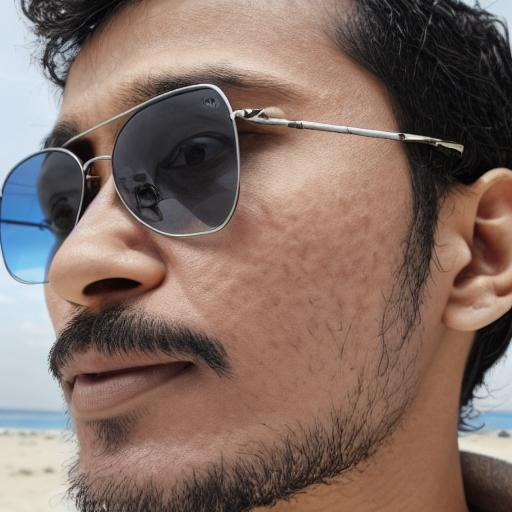

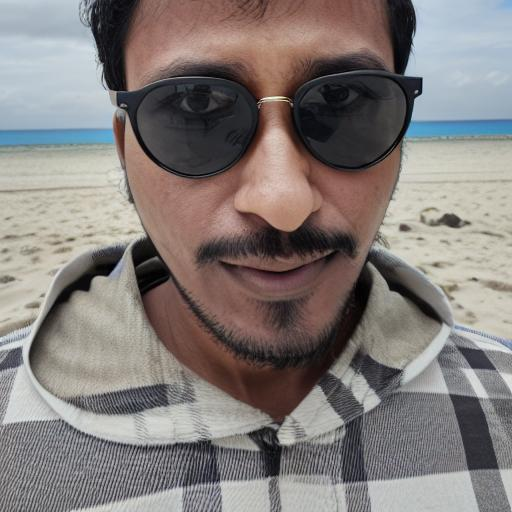


### LoRA Generated Images:


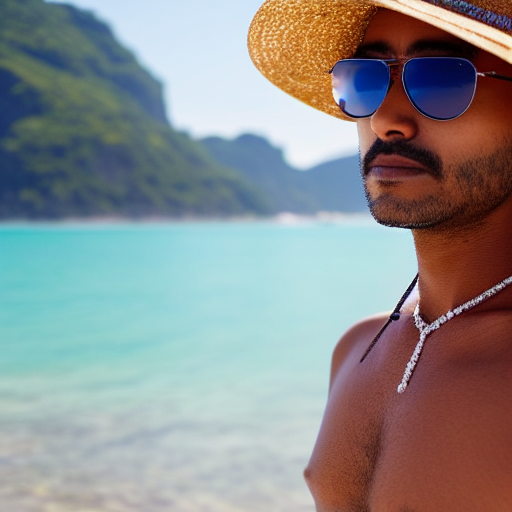

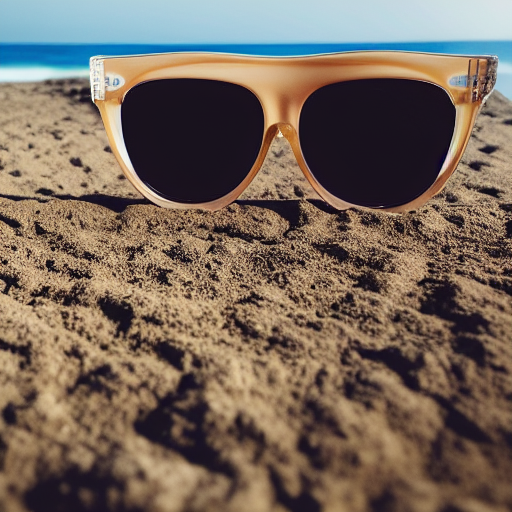

In [19]:

# =======================================================================================
# STEP 5: DISPLAY GENERATED IMAGES
# =======================================================================================
print("\n STEP 5: Displaying generated images for visual comparison...")
from PIL import Image
from IPython.display import display

print("\n### DreamBooth Generated Image:")
try:
    display(Image.open(dreambooth_image_path_0))
    display(Image.open(dreambooth_image_path_1))
    
except:
    print(" Could not display DreamBooth image.")

print("\n### LoRA Generated Images:")
try:
    display(Image.open(lora_image_path_0))
    display(Image.open(lora_image_path_1))
except:
    print(" Could not display LoRA images.")